## The data

The data was scraped from wine reviews on the WineEnthusiast website (winemag.com) in 2017. There are 130,000 reviews included and 10 features recorded: 
- country: The country that the wine is from
- description: A few sentences from a sommelier describing the wine's taste, smell, look, feel, etc.
- designation: The vineyard within the winery where the grapes that made the wine are from
- points: The number of points WineEnthusiast rated the wine on a scale of 1-100
- price: The cost for a bottle of the wine
- province: The province or state that the wine is from
- region_1: The wine growing area in a province or state
- region_2: Sometimes there are more specific regions specified within a wine growing area
- variety: The type of grapes used to make the wine
- winery: The winery that made the wine

(Source: https://www.kaggle.com/zynicide/wine-reviews)

# Analysis tools
For this analysis, we will focus on the wine descriptions. We use the word2vec word embedding to extract features for modeling. The gensim package (https://radimrehurek.com/gensim/index.html) was built "to realize unsupervised semantic modelling from plain text", and its implementation of word2vec is highly used. Word2vec uses neural networks to learn word embeddings from a corpus

Genism word2vec requires a "list of lists" input for training. This means that every document is contained in a list, every list contains lists of tokens of that document.

For easier computation, we randomly sampled 3000 descriptions from the data.

In [2]:
import gensim 
from gensim.models import Word2Vec

import nltk
from nltk.cluster import KMeansClusterer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk
import numpy as np
import pandas as pd
import re

from sklearn import cluster
from sklearn import metrics

# Preprocessing
For this demonstration, the raw text input will be preprocessed by 
- tokenizing the wine descriptions
- removing special characters
- stemming words

# Training data

In [5]:
data = pd.read_csv('winemag-data_first150k.csv')
data = data.sample(n=3000, replace=False, random_state=20)
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
49827,49827,US,"A superb white wine, and at this price, buy it...",NaN,90,10.0,California,California,California Other,White Blend,Kitchen Sink
80693,80693,US,"This shows deep, classic flavors of sweet blac...",Estate,89,60.0,California,Oakville,Napa,Cabernet Sauvignon,Ghost Block
135476,135476,US,Rugged tannins are front and center in this yo...,NaN,92,22.0,California,Mendocino County,Mendocino/Lake Counties,Syrah,Eaglepoint Ranch
139565,139565,US,"Here's an elegant, full-bodied Syrah that tast...",NaN,90,20.0,California,Mendocino,Mendocino/Lake Counties,Syrah,Jepson
57294,57294,Italy,"Made with organically farmed grapes, this pret...",Ombrone,93,68.0,Tuscany,Sant'Antimo,NaN,Red Blend,Cupano


In [6]:
ps = PorterStemmer()
descriptions = map(lambda x: [ps.stem(word) for word in word_tokenize(x) if word.isalpha()], data['description'])
descriptions = list(descriptions)

### Model parameters
- min_count: min_count (int, optional) – Ignores all words with total frequency lower than this.
- sg ({0, 1}, optional) – Training algorithm: 1 for skip-gram; otherwise CBOW.

In [7]:
model = Word2Vec(descriptions, min_count=2, sg=1) #This step takes time!

In [8]:
print(len(list(model.wv.vocab)))

2919


### A word embedding

In [9]:
model.wv['oak']

array([-0.07597971,  0.1310538 , -0.32771713,  0.3004645 , -0.4521803 ,
       -0.2689255 ,  0.1590628 ,  0.02296594,  0.04724645,  0.07343256,
        0.16933341,  0.10677838,  0.01709262, -0.09936614, -0.02129284,
        0.07412095,  0.09390995,  0.04142635,  0.12270662,  0.09816582,
        0.16794205, -0.02665637,  0.05980275, -0.21308044,  0.02869127,
       -0.21950397,  0.28281513,  0.1403475 ,  0.0506718 ,  0.00360228,
       -0.18074654, -0.36003575, -0.06726761,  0.29333365, -0.14979821,
        0.06029473,  0.1802619 ,  0.08294801, -0.13173887,  0.02355442,
       -0.33699578, -0.1778378 ,  0.02191857,  0.04160624,  0.04238753,
       -0.07926471, -0.27050608,  0.10234746, -0.1069548 , -0.24292292,
       -0.02462904, -0.36222184,  0.15740441,  0.15079224,  0.51064473,
       -0.15379298, -0.18687117, -0.07223091, -0.14384586, -0.04382729,
        0.14086007, -0.14114599,  0.10078683,  0.48006043, -0.06596691,
        0.2380501 ,  0.08179691,  0.10501269, -0.00507511, -0.30

### What words are most similar, given a word of interest?

In [10]:
pd.DataFrame(model.wv.similar_by_word('sweet'))

,0,1
0,toasti,0.935635
1,coat,0.929530
2,subtl,0.928092
3,oaki,0.920242
4,butteri,0.918254
5,flood,0.918093
6,syrupi,0.917891
7,candi,0.917571
8,sticki,0.913546
9,minti,0.911939


In [11]:
pd.DataFrame(model.wv.similar_by_word('aroma'))

,0,1
0,scent,0.950055
1,rose,0.949290
2,petal,0.939767
3,tone,0.933913
4,forest,0.930852
5,violet,0.929514
6,exot,0.925442
7,powder,0.924529
8,mix,0.917831
9,crush,0.917121


In [12]:
pd.DataFrame(model.wv.similar_by_word('smooth'))

,0,1
0,velveti,0.985352
1,suppl,0.984060
2,chewi,0.960713
3,silki,0.958493
4,weight,0.950627
5,solid,0.948345
6,textur,0.946961
7,bodi,0.945192
8,moder,0.941951
9,tight,0.940913


### How similar are two words?

In [14]:
print(model.wv.similarity('smooth', 'aroma'))

print(model.wv.similarity('sweet', 'smoke'))

print(model.wv.similarity('valley', 'fruit'))

0.5425669
0.70126396
0.4152811


# Clustering
In order to cluster at the sentence/description level, we will summarize the embeddings. For each description, the word embedding of each word is summed and then divided by the number of words in the description.

In [15]:
def desc_vectorizer(desc, model):
    desc_vec =[]
    numw = 0
    for w in desc:
        try:
            if numw == 0:
                desc_vec = model.wv[w]
            else:
                desc_vec = np.add(desc_vec, model.wv[w])
            numw+=1
        except:
            pass
     
    return np.asarray(desc_vec) / numw

In [16]:
X = []
for d in descriptions:
    X.append(desc_vectorizer(d, model))

In [17]:
X[0]

array([ 1.11052744e-01,  3.15503240e-01, -1.79306492e-01,  8.35840702e-02,
       -2.76175767e-01, -7.13394880e-02, -2.48630736e-02, -7.34239295e-02,
        2.09095314e-01,  2.50062551e-02,  2.05645606e-01,  1.51700571e-01,
        4.85038236e-02,  4.82370518e-02, -1.87018812e-01,  4.35862392e-02,
        2.19483040e-02,  4.07208540e-02,  3.11185300e-01,  8.91603976e-02,
        1.50228158e-01, -1.34339541e-01,  1.30573362e-02, -2.91869760e-01,
       -3.98844555e-02,  4.56932262e-02, -9.64331180e-02,  1.27742574e-01,
        5.36179766e-02, -5.73386177e-02, -2.72723049e-01, -1.56705409e-01,
        1.89898387e-01,  1.19654603e-01, -9.77070034e-02,  1.08215354e-01,
        2.51348674e-01,  1.21520109e-01, -2.86763221e-01,  1.61906909e-02,
       -2.03912050e-01, -2.76909828e-01, -1.61383405e-01, -8.49592239e-02,
       -1.99470180e-03, -1.89555380e-02, -2.39270195e-01,  8.91750157e-02,
       -1.86875850e-01, -8.72319117e-02,  1.27924969e-02, -3.85179400e-01,
        5.86738624e-02,  

# K-means clustering

### 2 clusters

In [21]:
NUM_CLUSTERS = 2
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
print(assigned_clusters[:3]) 

[0, 0, 0]


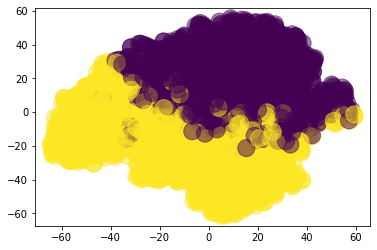

In [24]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsnemodel = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)

Y = tsnemodel.fit_transform(X)

plt.scatter(Y[:, 0], Y[:, 1], c=assigned_clusters, s=290,alpha=.5)
plt.show()

### 4 clusters

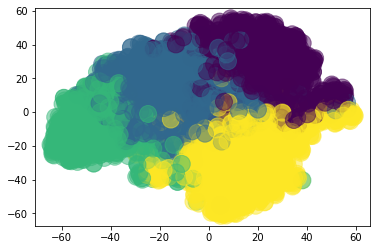

In [25]:
NUM_CLUSTERS = 4
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
tsnemodel = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)

Y = tsnemodel.fit_transform(X)

plt.scatter(Y[:, 0], Y[:, 1], c=assigned_clusters, s=290,alpha=.5)
plt.show()